This is an example notbook that shows how to query the apsViz timeseries data base using the Django Rest Framework (DRF) API, and then plot the output.

In [1]:
import requests, urllib.request, json, time, pdb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

In [2]:
def plotGauges(dfplot,savefig):
    fig, axs = plt.subplots(figsize=(20, 6))
    dfplot.plot(kind='line', x='time', ax=axs)
    fig.autofmt_xdate()
    axs.set_xlabel("datetime")
    axs.set_ylabel("water level in meters")
    if savefig == 'yes':
        fig.savefig('test_graph.png')

The first thing to understand is that the default page size for DRF is set to 10, so to get more data you need to use the variable psize. In the URL below I have psize set to 100000, which is more than enough the the queries we need to do.

The URL below queries the gauge_timemark view, which returns unique timemark values. The timemark values are the times used in the CSV filenames. 

In the case of the ADCIRC data the timemark is the last timestep, for each station, in the nowcast file, and timestep before the first timestep, for each station, in the forecast file. Along with data_source they can be used to uniquely identify a model run.

The timemark in the NOAA and NCEM observation files is the last timestep, for each station.

The purpose of the gauge_timemark view is to identify the forecast model run that is to be compared with the observation and nowcast data.

The variables used in the URL below are fields, data_source, station_name, time, psize, which I have already explained, and format.

The variable format specifies the format the output data is in. The URL below returns the data in json, which is currently the only option. 

The variable fields is used to define specific colums to pull. If fields is not used, all the columns in the table are pulled. In the example below I am only pulling data for the timemark, and data_source column. These columns are what we need to identify a specific model run, and limiting the columns makes it easier to interpret the results. 

The variable data_source identifies the source of the data. Currently there are five sources of data. 

In the case of ADIRC data they provide information on the type of model run, and the grid used in the model run. The current two ADCIRC data_source are namforecast_hsofs, and nowcast_hsofs. In the future we will have additional ADCIRC data source as different grids are used, and ensemble are run.

In the case of the observation data they provide information on the type of gauge. The data_source for the NOAA data is tidal_gauge, and the data_source for the NCEM data is coastal_gauge, and river_gauge.

The variable station_name is a unique identifier for each gauge station.

The variable time is the timestep for each observation of model run value. Below the values gt and lt are added to the time variable, using two underscorces. This enables query data between two dates.

In [3]:
urlstr = 'http://apsviz-timeseriesdb.edc.renci.org/api/gauge_timemark/?fields=timemark,data_source&data_source=namforecast_hsofs&station_name=8651370&time__gt=2022-02-16T00:00:00Z&time__lt=2022-02-17T00:00:00Z&psize=100000&format=json'

start_time = datetime.now() 
with urllib.request.urlopen(urlstr) as url:
    data = json.loads(url.read().decode())
    fcdf = pd.json_normalize(data, record_path = ['results'])
time_elapsed = datetime.now() - start_time 
print('Time elapsed (hh:mm:ss.ms) {}'.format(time_elapsed))

fcdf.head(30)

Time elapsed (hh:mm:ss.ms) 0:00:00.324542


,timemark,data_source
0,2022-02-12T18:00:00Z,namforecast_hsofs
1,2022-02-13T00:00:00Z,namforecast_hsofs
2,2022-02-13T06:00:00Z,namforecast_hsofs
3,2022-02-13T12:00:00Z,namforecast_hsofs
4,2022-02-13T18:00:00Z,namforecast_hsofs
5,2022-02-14T00:00:00Z,namforecast_hsofs
6,2022-02-14T06:00:00Z,namforecast_hsofs
7,2022-02-14T12:00:00Z,namforecast_hsofs
8,2022-02-14T18:00:00Z,namforecast_hsofs
9,2022-02-15T00:00:00Z,namforecast_hsofs


Below I have selected the timemark 2022-02-15T00:00:00Z which will be used in the next URL to query gauge data from the gauge_station_source_data view. I have also created a start date, from the timemark date, which is five days befor the timemark. This will be used in the URL to define a date range to query the observation gauge data, and nowcast data.

In [4]:
#timemark = fcdf['timemark'][18]
timemark = fcdf['timemark'][12]
fdatetime = datetime.fromisoformat(" ".join(timemark.split('T'))[0:-1])
DAYS = timedelta(5)
startdt = "T".join(str(fdatetime - DAYS).split(' '))+'Z'
station_name = '8651370'
gauge_source = 'tidal_gauge'
#gauge_source = 'tidal_shit'
#station_name = 'ORLN7'
#gauge_source = 'coastal_gauge'

The URL below pulls tidal gauge and nowcast data for station 8651370 with a date range based on startdt and timemark above. To pull only tidal and nowcast data the "in" option is added to the data_source variable using two underscores.

After the data has been pulled and added to a dataframe (dfn), new dataframes are created (dfnc, dftg, and dfnew) which seperate the tidal gauge and nowcast data, and then recombines them into a simplified dataframe for ploting. Before the are recombined they are reduced to just the time and water level variables and duplicate times are removed.

The dfnew data frame is then used to plot the data.

Question: Why not use the variable fields in the URL to only pull data for columns time and water_level?

Unfortunately, the DRF module (QueryFieldsMixin) which enable the use of fields, conflicts with the DRF module (GeoFeatureModelSerializer) which enables geospatial queries. 

Question: Why do duplicate times need to be removed?

There is overlap times in the NOAA tidal gauge data, however the water level values are the same. In other cases the water level values may differ, so the method below would not be the best option. One option would be to deal with the duplicate times in the postgreSQL data table (drf_harvest_data_file_meta). There has been discussions in the past to update the data, as it is ingested, over writing the older data. However, updating data in much slower than using the SQL copy command to insert data. Another solution would be to develop a SQL query the delets data that has duplicate times, where the water level values differ. This is probably the best solution, since deleting data is very fast.

In [5]:
print(startdt, timemark)

2022-02-10T18:00:00Z 2022-02-15T18:00:00Z


Time elapsed (hh:mm:ss.ms) 0:00:01.665318


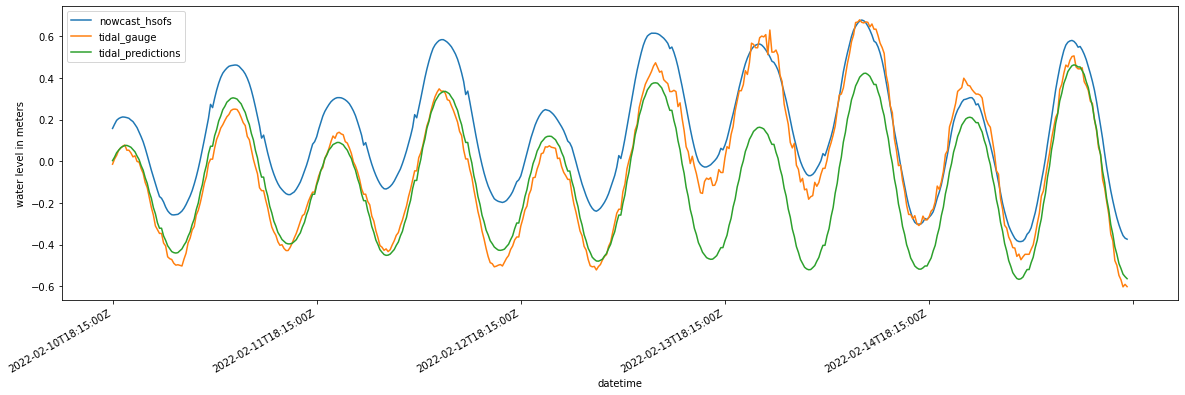

In [6]:
#urlstr = 'http://apsviz-timeseriesdb.edc.renci.org/api/gauge_station_source_data/?station_name='+station_name+'&data_source__in='+gauge_source+',nowcast_hsofs&time__gt='+startdt+'&time__lt='+timemark+'&psize=5000&format=json'
urlstr = 'http://apsviz-timeseriesdb.edc.renci.org/api/gauge_station_source_data/?station_name='+station_name+'&data_source__in='+gauge_source+',nowcast_hsofs,tidal_predictions&time__gt='+startdt+'&time__lt='+timemark+'&psize=5000&format=json'

start_time = datetime.now() 
with urllib.request.urlopen(urlstr) as url:
    data = json.loads(url.read().decode())

    if data['count'] == 0:
        dfn = pd.DataFrame(columns = ['properties.time', 'properties.water_level'])
    else:
        dfn = pd.json_normalize(data, record_path = ['results','features']).sort_values('properties.time')

time_elapsed = datetime.now() - start_time 
print('Time elapsed (hh:mm:ss.ms) {}'.format(time_elapsed))

dfn.replace(-99999.0,np.NaN, inplace=True)

dfnc = dfn.loc[dfn['properties.data_source'] == 'nowcast_hsofs'][['properties.time', 'properties.water_level']]
dfnc.columns = ['time','nowcast_hsofs']

dfgg = dfn.loc[dfn['properties.data_source'] == gauge_source][['properties.time', 'properties.water_level']]
dfgg.columns = ['time', gauge_source]

dfgp = dfn.loc[dfn['properties.data_source'] == 'tidal_predictions'][['properties.time', 'properties.water_level']]
dfgp.columns = ['time', 'tidal_predictions']

dfnowcast = dfnc.merge(dfgg, on="time").merge(dfgp, on="time")
    
plotGauges(dfnowcast, 'yes')

In [7]:
dfn.head()

,id,type,geometry.type,geometry.coordinates,properties.source_id,properties.station_id,properties.station_name,properties.timemark,properties.time,properties.water_level,...,properties.units,properties.gauge_owner,properties.data_source,properties.source_name,properties.source_archive,properties.location_name,properties.location_type,properties.country,properties.state,properties.county
1455,38435114,Feature,Point,"[-75.746694, 36.183306]",2655,58,8651370,2022-02-12T00:00:00Z,2022-02-10T18:15:00Z,-0.014000,...,m,NOAA/NOS,tidal_gauge,noaa,noaa,Duck,tidal,us,nc,Dare
1447,21615613,Feature,Point,"[-75.746694, 36.183306]",1064,58,8651370,2022-02-11T00:00:00Z,2022-02-10T18:15:00Z,0.157275,...,m,NOAA/NOS,nowcast_hsofs,adcirc,renci,Duck,tidal,us,nc,Dare
1454,28783956,Feature,Point,"[-75.746694, 36.183306]",304,58,8651370,2022-02-12T00:00:00Z,2022-02-10T18:15:00Z,0.003000,...,m,NOAA/NOS,tidal_predictions,noaa,noaa,Duck,tidal,us,nc,Dare
1451,21615614,Feature,Point,"[-75.746694, 36.183306]",1064,58,8651370,2022-02-11T00:00:00Z,2022-02-10T18:30:00Z,0.177565,...,m,NOAA/NOS,nowcast_hsofs,adcirc,renci,Duck,tidal,us,nc,Dare
1453,38435115,Feature,Point,"[-75.746694, 36.183306]",2655,58,8651370,2022-02-12T00:00:00Z,2022-02-10T18:30:00Z,0.011000,...,m,NOAA/NOS,tidal_gauge,noaa,noaa,Duck,tidal,us,nc,Dare


The URL below pulls nameforecast_hsofs data for station 8651370, that has the timemark selected above. The data is added to a dataframe, which is then simplified to just the time, and water_level columns and combined with the dfnew dataframe for plotting.

Time elapsed (hh:mm:ss.ms) 0:00:07.975983


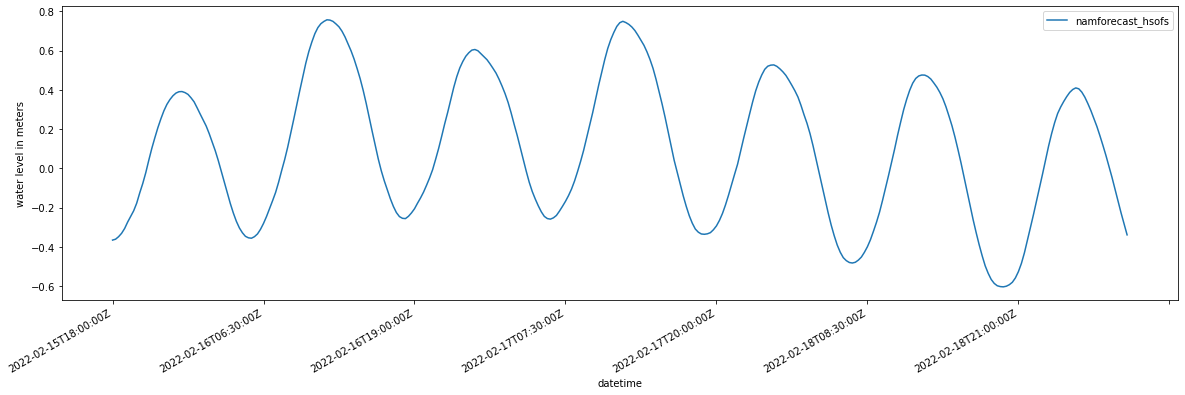

In [8]:
urlstr = 'http://apsviz-timeseriesdb.edc.renci.org/api/gauge_station_source_data/?station_name='+station_name+'&data_source=namforecast_hsofs&timemark='+timemark+'&psize=5000&format=json'
#urlstr = 'http://apsviz-timeseriesdb.edc.renci.org/api/gauge_station_source_data/?station_name='+station_name+'&data_source=namforecast_hsofs,tidal_predictions&timemark='+timemark+'&psize=5000&format=json'

start_time = datetime.now() 
with urllib.request.urlopen(urlstr) as url:
    data = json.loads(url.read().decode())
    if data['count'] == 0:
        dff = pd.DataFrame(columns = ['properties.time', 'properties.water_level'])
    else:
        dff = pd.json_normalize(data, record_path = ['results','features']).sort_values('properties.time')
time_elapsed = datetime.now() - start_time 
print('Time elapsed (hh:mm:ss.ms) {}'.format(time_elapsed))

dff.replace(-99999.0,np.NaN, inplace=True)

dffc = dff[['properties.time', 'properties.water_level']]
dffc.columns = ['time','namforecast_hsofs']

plotGauges(dffc, 'yes')

In [9]:
dff.head()

,id,type,geometry.type,geometry.coordinates,properties.source_id,properties.station_id,properties.station_name,properties.timemark,properties.time,properties.water_level,...,properties.units,properties.gauge_owner,properties.data_source,properties.source_name,properties.source_archive,properties.location_name,properties.location_type,properties.country,properties.state,properties.county
217,7138605,Feature,Point,"[-75.746694, 36.183306]",2425,58,8651370,2022-02-15T18:00:00Z,2022-02-15T18:00:00Z,-0.366058,...,m,NOAA/NOS,namforecast_hsofs,adcirc,renci,Duck,tidal,us,nc,Dare
218,7138606,Feature,Point,"[-75.746694, 36.183306]",2425,58,8651370,2022-02-15T18:00:00Z,2022-02-15T18:15:00Z,-0.361525,...,m,NOAA/NOS,namforecast_hsofs,adcirc,renci,Duck,tidal,us,nc,Dare
219,7138607,Feature,Point,"[-75.746694, 36.183306]",2425,58,8651370,2022-02-15T18:00:00Z,2022-02-15T18:30:00Z,-0.348682,...,m,NOAA/NOS,namforecast_hsofs,adcirc,renci,Duck,tidal,us,nc,Dare
220,7138608,Feature,Point,"[-75.746694, 36.183306]",2425,58,8651370,2022-02-15T18:00:00Z,2022-02-15T18:45:00Z,-0.331457,...,m,NOAA/NOS,namforecast_hsofs,adcirc,renci,Duck,tidal,us,nc,Dare
221,7138609,Feature,Point,"[-75.746694, 36.183306]",2425,58,8651370,2022-02-15T18:00:00Z,2022-02-15T19:00:00Z,-0.306978,...,m,NOAA/NOS,namforecast_hsofs,adcirc,renci,Duck,tidal,us,nc,Dare


Time elapsed (hh:mm:ss.ms) 0:00:00.797796


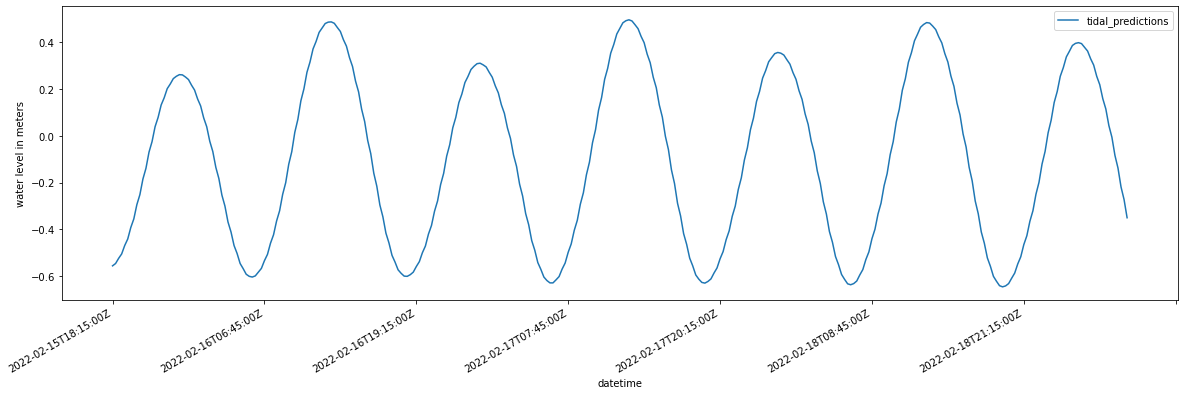

In [10]:
begin_date = timemark #dfnowcast['time'].iat[0]
end_date = dffc['time'].iat[-1]
urlstr = 'http://apsviz-timeseriesdb.edc.renci.org/api/gauge_station_source_data/?station_name='+station_name+'&data_source=tidal_predictions&time__gt='+begin_date+'&time__lt='+end_date+'&psize=5000&format=json'

start_time = datetime.now() 
with urllib.request.urlopen(urlstr) as url:
    data = json.loads(url.read().decode())
    if data['count'] == 0:
        dfp = pd.DataFrame(columns = ['properties.time', 'properties.water_level'])
    else:
        dfp = pd.json_normalize(data, record_path = ['results','features']).sort_values('properties.time')
time_elapsed = datetime.now() - start_time 
print('Time elapsed (hh:mm:ss.ms) {}'.format(time_elapsed))

dfp.replace(-99999.0,np.NaN, inplace=True)
dfgp = dfp[['properties.time', 'properties.water_level']]
dfgp.columns = ['time','tidal_predictions']

plotGauges(dfgp, 'yes')

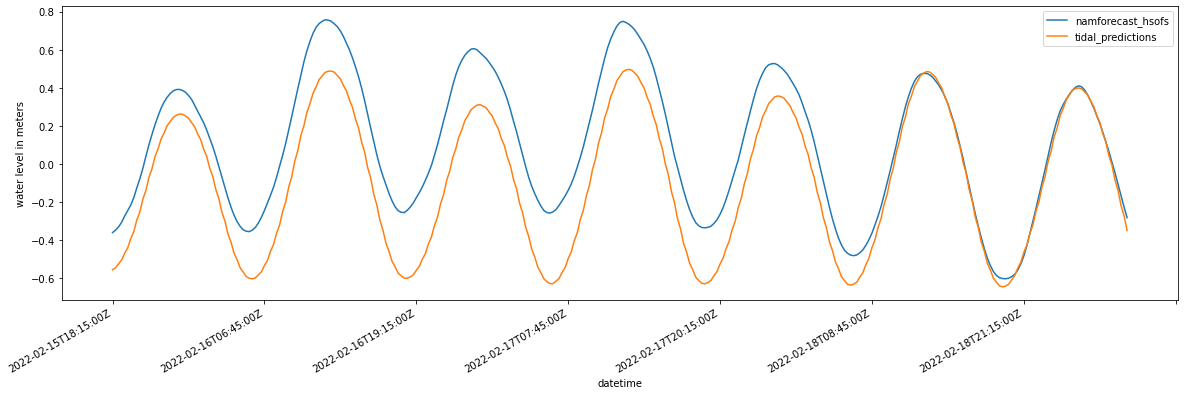

In [11]:
dfforecast = pd.merge(dffc, dfgp, how='right', on=['time'])
plotGauges(dfforecast, 'yes')

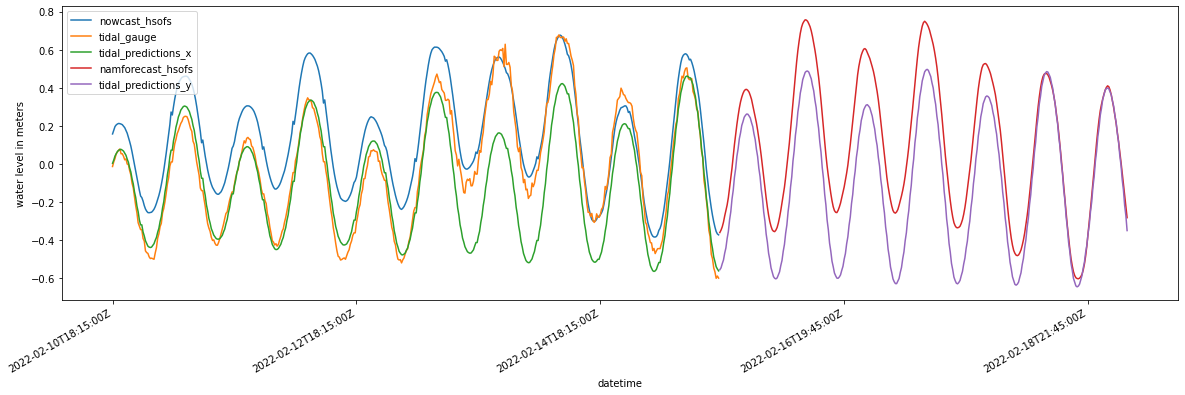

In [12]:
dfallcast = pd.merge(dfnowcast, dfforecast, how='outer', on=['time'])
plotGauges(dfallcast, 'yes')

Time elapsed (hh:mm:ss.ms) 0:00:00.872252


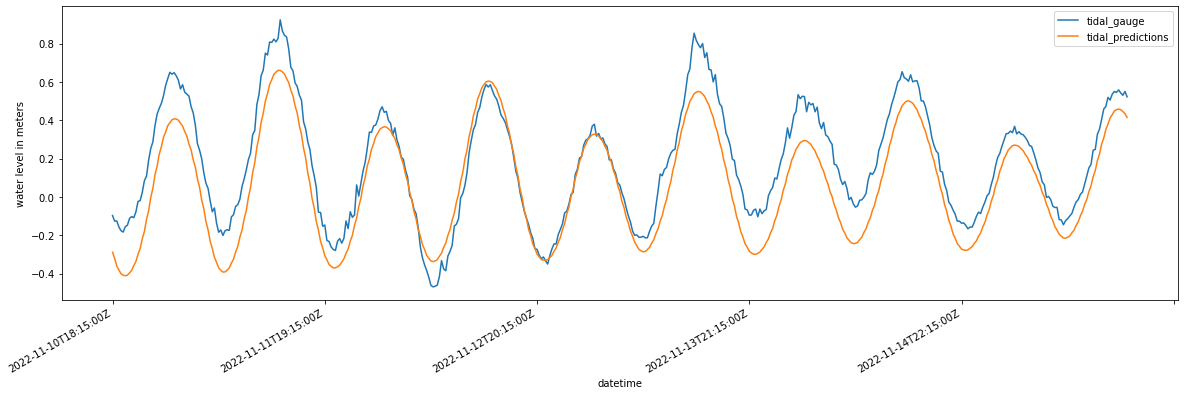

In [13]:
startdt = '2022-11-10T18:00:00Z'
timemark = '2022-11-15T18:00:00Z'
urlstr = 'https://test-apsviz-timeseries.apps.renci.org/api/gauge_station_source_data/?station_name='+station_name+'&data_source__in='+gauge_source+',tidal_predictions&time__gt='+startdt+'&time__lt='+timemark+'&psize=5000&format=json'

start_time = datetime.now() 
with urllib.request.urlopen(urlstr) as url:
    data = json.loads(url.read().decode())

    if data['count'] == 0:
        dfn = pd.DataFrame(columns = ['properties.time', 'properties.water_level'])
    else:
        dfn = pd.json_normalize(data, record_path = ['results','features']).sort_values('properties.time')

time_elapsed = datetime.now() - start_time 
print('Time elapsed (hh:mm:ss.ms) {}'.format(time_elapsed))

dfn.replace(-99999.0,np.NaN, inplace=True)

dfgg = dfn.loc[dfn['properties.data_source'] == gauge_source][['properties.time', 'properties.water_level']]
dfgg.columns = ['time', gauge_source]

dfgp = dfn.loc[dfn['properties.data_source'] == 'tidal_predictions'][['properties.time', 'properties.water_level']]
dfgp.columns = ['time', 'tidal_predictions']

dfduck = dfgg.merge(dfgp, on="time")
    
plotGauges(dfduck, 'yes')